## Installing Required Libraries

## Importing required Libraries

In [2]:
import pandas as pd
import numpy as np
import json
import re
from typing import List, Dict, Any, Tuple
from sentence_transformers import SentenceTransformer
from openai import OpenAI
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from dotenv import load_dotenv
import openai
import os
from langchain_community.utilities import GoogleSerperAPIWrapper



# ✅ Load environment variables
load_dotenv()
openai_api_key = os.getenv("OPEN_AI_KEY")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")



In [ ]:
from datasets import load_dataset

ds = load_dataset("deccan-ai/insuranceQA-v2")



### Setting up the FAQ Data

In [70]:
from datasets import load_dataset
import pandas as pd

# Load the dataset from Hugging Face
ds = load_dataset("deccan-ai/insuranceQA-v2")

# Combine all splits into a single DataFrame
df = pd.concat([split.to_pandas() for split in ds.values()], ignore_index=True)
df["combined"] = "Question: " + df["input"] + " \n Answer:  " + df["output"]
# Inspect
df.head()


,input,output,combined
0,What Does Medicare IME Stand For?,According to the Centers for Medicare and Medi...,Question: What Does Medicare IME Stand For? \...
1,Is Long Term Care Insurance Tax Free?,"As a rule , if you buy a tax qualified long te...",Question: Is Long Term Care Insurance Tax Free...
2,Can Husband Drop Wife From Health Insurance?,Can a spouse drop another spouse from health i...,Question: Can Husband Drop Wife From Health In...
3,Is Medicare Run By The Government?,Medicare Part A and Part B is provided by the ...,Question: Is Medicare Run By The Government? ...
4,Is Medicare Run By The Government?,Definitely . It is ran by the Center for Medic...,Question: Is Medicare Run By The Government? ...


In [71]:
import chromadb
# Setting up the Chromadb
client = chromadb.PersistentClient(path="./chroma_db")

In [ ]:
# Collection 1 for insurance Q&A Dataset
from tqdm import tqdm
collection = client.get_or_create_collection(name="insurance_FAQ_collection")
# Add data to collection
# here the chroma db will use default embeddings (sentence transformers)
# Split into batches of <= 5000
batch_size = 5000

for i in tqdm(range(0, len(df), batch_size)):
    batch_df = df.iloc[i:i+batch_size]
    collection.add(
        documents=batch_df["combined"].tolist(),
        metadatas=[{"question": q, "answer": a} for q, a in zip(batch_df["input"], batch_df["output"])],
        ids=batch_df.index.astype(str).tolist()
    )




 83%|████████▎ | 5/6 [16:10<03:24, 204.56s/it]

In [ ]:
## Testing the retrieval
query = "What does life insurance cover?"

results = collection.query(
    query_texts=[query],
    n_results=3,
    include=["metadatas", "documents"]
)

for i, m in enumerate(results["metadatas"][0]):
    print(f"Result {i+1}:")
    print("Score:", results["distances"][0][i])
    print("Q:", m["question"])
    print("A:", m["answer"])
    print("-" * 50)


## Generating Synthetic Data

In [24]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

def generate_sample_data():
    """Generate enriched sample data for all tables with 50 first/last names"""
    # Define 50 first and last names
    first_names = [
        "John", "Jane", "Robert", "Maria", "David", "Lisa", "Michael", "Sarah", "James", "Emily",
        "William", "Emma", "Joseph", "Olivia", "Charles", "Ava", "Thomas", "Isabella", "Daniel", "Mia",
        "Matthew", "Sophia", "Anthony", "Charlotte", "Christopher", "Amelia", "Andrew", "Harper",
        "Joshua", "Evelyn", "Ryan", "Abigail", "Brandon", "Ella", "Justin", "Scarlett", "Tyler", "Grace",
        "Alexander", "Chloe", "Kevin", "Victoria", "Jason", "Lily", "Brian", "Hannah", "Eric", "Aria",
        "Kyle", "Zoey"
    ]

    last_names = [
        "Smith", "Johnson", "Williams", "Brown", "Jones", "Garcia", "Miller", "Davis", "Rodriguez", "Martinez",
        "Hernandez", "Lopez", "Gonzalez", "Wilson", "Anderson", "Thomas", "Taylor", "Moore", "Jackson", "Martin",
        "Lee", "Perez", "Thompson", "White", "Harris", "Sanchez", "Clark", "Ramirez", "Lewis", "Robinson",
        "Walker", "Young", "Allen", "King", "Wright", "Scott", "Torres", "Nguyen", "Hill", "Flores",
        "Green", "Adams", "Nelson", "Baker", "Hall", "Rivera", "Campbell", "Mitchell", "Carter", "Roberts"
    ]

    # Generate customers (1000 random name combinations)
    customers = pd.DataFrame({
        'customer_id': [f'CUST{str(i).zfill(5)}' for i in range(1, 1001)],
        'first_name': [random.choice(first_names) for _ in range(1000)],
        'last_name': [random.choice(last_names) for _ in range(1000)],
        'email': [f'user{i}@example.com' for i in range(1, 1001)],
        'phone': [f'555-{str(random.randint(100,999)).zfill(3)}-{str(random.randint(1000,9999)).zfill(4)}' for _ in range(1000)],
        'date_of_birth': [datetime(1980, 1, 1) + timedelta(days=random.randint(0, 10000)) for _ in range(1000)],
        'state': [random.choice(['CA', 'NY', 'TX', 'FL', 'IL', 'PA', 'OH', 'GA']) for _ in range(1000)]
    })

    # Policies
    policies = pd.DataFrame({
        'policy_number': [f'POL{str(i).zfill(6)}' for i in range(1, 1501)],
        'customer_id': [f'CUST{str(random.randint(1, 1000)).zfill(5)}' for _ in range(1500)],
        'policy_type': [random.choice(['auto', 'home', 'life']) for _ in range(1500)],
        'start_date': [datetime(2023, 1, 1) + timedelta(days=random.randint(0, 365)) for _ in range(1500)],
        'premium_amount': [round(random.uniform(50, 500), 2) for _ in range(1500)],
        'billing_frequency': [random.choice(['monthly', 'quarterly', 'annual']) for _ in range(1500)],
        'status': [random.choice(['active', 'active', 'active', 'cancelled']) for _ in range(1500)]
    })

    # Auto Policy Details (subset)
    auto_policies = policies[policies['policy_type'] == 'auto'].copy()
    auto_policy_details = pd.DataFrame({
        'policy_number': auto_policies['policy_number'],
        'vehicle_vin': [f'VIN{random.randint(10000000000000000, 99999999999999999)}' for _ in range(len(auto_policies))],
        'vehicle_make': [random.choice(['Toyota', 'Honda', 'Ford', 'Chevrolet', 'Nissan']) for _ in range(len(auto_policies))],
        'vehicle_model': [random.choice(['Camry', 'Civic', 'F-150', 'Malibu', 'Altima']) for _ in range(len(auto_policies))],
        'vehicle_year': [random.randint(2015, 2023) for _ in range(len(auto_policies))],
        'liability_limit': [random.choice([50000, 100000, 300000]) for _ in range(len(auto_policies))],
        'collision_deductible': [random.choice([250, 500, 1000]) for _ in range(len(auto_policies))],
        'comprehensive_deductible': [random.choice([250, 500, 1000]) for _ in range(len(auto_policies))],
        'uninsured_motorist': [random.choice([0, 1]) for _ in range(len(auto_policies))],
        'rental_car_coverage': [random.choice([0, 1]) for _ in range(len(auto_policies))]
    })

    # Payment Methods
    payment_methods = pd.DataFrame({
        'method_id': [f'PM{str(i).zfill(6)}' for i in range(1, 1501)],
        'customer_id': [f'CUST{str(random.randint(1, 1000)).zfill(5)}' for _ in range(1500)],
        'payment_type': [random.choice(['credit_card', 'debit_card', 'bank_account']) for _ in range(1500)],
        'last_four_digits': [f'{random.randint(1000,9999)}' for _ in range(1500)],
        'expiry_date': [f'202{random.randint(5,8)}-{random.randint(1,12):02d}-{random.randint(1,28):02d}' for _ in range(1500)],
        'is_default': [random.choice([0, 1]) for _ in range(1500)]
    })

    # Billing
    billing = pd.DataFrame({
        'bill_id': [f'BILL{str(i).zfill(6)}' for i in range(1, 5001)],
        'policy_number': [random.choice(policies['policy_number']) for _ in range(5000)],
        'billing_date': [datetime(2024, 1, 1) + timedelta(days=random.randint(0, 90)) for _ in range(5000)],
        'due_date': [datetime(2024, 1, 15) + timedelta(days=random.randint(0, 90)) for _ in range(5000)],
        'amount_due': [round(random.uniform(100, 1000), 2) for _ in range(5000)],
        'status': [random.choice(['paid', 'pending', 'overdue']) for _ in range(5000)]
    })

    # Payments
    payments = pd.DataFrame({
        'payment_id': [f'PAY{str(i).zfill(6)}' for i in range(1, 4001)],
        'bill_id': [random.choice(billing['bill_id']) for _ in range(4000)],
        'payment_date': [datetime(2024, 1, 1) + timedelta(days=random.randint(0, 90)) for _ in range(4000)],
        'amount': [round(random.uniform(50, 500), 2) for _ in range(4000)],
        'payment_method': [random.choice(['credit_card', 'debit_card', 'bank_transfer']) for _ in range(4000)],
        'transaction_id': [f'TXN{random.randint(100000,999999)}' for _ in range(4000)],
        'status': [random.choice(['completed', 'pending', 'failed']) for _ in range(4000)]
    })

    # Claims
    claims = pd.DataFrame({
        'claim_id': [f'CLM{str(i).zfill(6)}' for i in range(1, 301)],
        'policy_number': [random.choice(policies['policy_number']) for _ in range(300)],
        'claim_date': [datetime(2024, 1, 1) + timedelta(days=random.randint(0, 90)) for _ in range(300)],
        'incident_type': [random.choice(['collision', 'theft', 'property_damage', 'medical', 'liability']) for _ in range(300)],
        'estimated_loss': [round(random.uniform(500, 20000), 2) for _ in range(300)],
        'status': [random.choice(['submitted', 'under_review', 'approved', 'paid', 'denied']) for _ in range(300)]
    })

    # Claim Documents
    claim_documents = pd.DataFrame({
        'document_id': [f'DOC{str(i).zfill(6)}' for i in range(1, 601)],
        'claim_id': [random.choice(claims['claim_id']) for _ in range(600)],
        'document_type': [random.choice(['photo', 'police_report', 'estimate', 'invoice']) for _ in range(600)],
        'document_url': [f'https://example.com/documents/{i}.pdf' for i in range(1, 601)],
        'uploaded_date': [datetime.now() - timedelta(days=random.randint(0, 60)) for _ in range(600)]
    })

    return {
        'customers': customers,
        'policies': policies,
        'auto_policy_details': auto_policy_details,
        'payment_methods': payment_methods,
        'billing': billing,
        'payments': payments,
        'claims': claims,
        'claim_documents': claim_documents
    }


sample_data = generate_sample_data()

In [31]:
print("Custimers Data Shape:", sample_data["customers"].shape)
sample_data["customers"].head()

Custimers Data Shape: (1000, 7)


,customer_id,first_name,last_name,email,phone,date_of_birth,state
0,CUST00001,Kyle,Gonzalez,user1@example.com,555-575-6604,1986-01-28,GA
1,CUST00002,Ella,Green,user2@example.com,555-107-6318,1982-03-26,FL
2,CUST00003,Thomas,Garcia,user3@example.com,555-903-8873,1995-06-13,CA
3,CUST00004,Kevin,Garcia,user4@example.com,555-922-9914,1997-05-09,NY
4,CUST00005,Chloe,Hill,user5@example.com,555-403-9021,1992-12-06,TX


In [32]:
print("billing Data Shape:", sample_data["billing"].shape)
sample_data["billing"].head()

billing Data Shape: (5000, 6)


,bill_id,policy_number,billing_date,due_date,amount_due,status
0,BILL000001,POL000421,2024-02-04,2024-02-13,145.70,overdue
1,BILL000002,POL000814,2024-01-03,2024-04-13,230.94,pending
2,BILL000003,POL000735,2024-01-23,2024-03-31,291.50,overdue
3,BILL000004,POL001437,2024-02-13,2024-01-21,657.87,overdue
4,BILL000005,POL001395,2024-03-27,2024-04-09,337.55,paid


In [33]:
print("claims Data Shape:", sample_data["claims"].shape)
sample_data["claims"].head()

claims Data Shape: (300, 6)


,claim_id,policy_number,claim_date,incident_type,estimated_loss,status
0,CLM000001,POL000487,2024-03-15,medical,16765.56,under_review
1,CLM000002,POL000734,2024-01-31,property_damage,6997.58,approved
2,CLM000003,POL000161,2024-03-05,collision,17465.39,under_review
3,CLM000004,POL000627,2024-02-29,theft,12879.10,paid
4,CLM000005,POL000794,2024-03-28,medical,13444.34,submitted


In [34]:
print("policies Data Shape:", sample_data["policies"].shape)
sample_data["policies"].head()

policies Data Shape: (1500, 7)


,policy_number,customer_id,policy_type,start_date,premium_amount,billing_frequency,status
0,POL000001,CUST00020,life,2023-01-19,102.92,monthly,cancelled
1,POL000002,CUST00637,auto,2023-01-20,396.33,quarterly,active
2,POL000003,CUST00955,home,2023-11-30,425.08,annual,cancelled
3,POL000004,CUST00305,life,2023-04-20,357.73,quarterly,active
4,POL000005,CUST00033,auto,2023-11-28,464.79,annual,cancelled


In [29]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import json


def connect_db(db_path='insurance_support.db'):
    """Connect to SQLite database"""
    return sqlite3.connect(db_path)


def drop_and_create_tables(conn):
    """Drop existing tables and recreate the schema"""
    cursor = conn.cursor()

    # Drop tables if exist
    cursor.executescript("""
        DROP TABLE IF EXISTS claim_documents;
        DROP TABLE IF EXISTS claims;
        DROP TABLE IF EXISTS payments;
        DROP TABLE IF EXISTS billing;
        DROP TABLE IF EXISTS payment_methods;
        DROP TABLE IF EXISTS auto_policy_details;
        DROP TABLE IF EXISTS policies;
        DROP TABLE IF EXISTS customers;
    """)

    # Create tables
    cursor.executescript("""
        CREATE TABLE customers (
            customer_id VARCHAR(20) PRIMARY KEY,
            first_name VARCHAR(50),
            last_name VARCHAR(50),
            email VARCHAR(100),
            phone VARCHAR(20),
            date_of_birth DATE,
            state VARCHAR(20)
        );

        CREATE TABLE policies (
            policy_number VARCHAR(20) PRIMARY KEY,
            customer_id VARCHAR(20),
            policy_type VARCHAR(50),
            start_date DATE,
            premium_amount DECIMAL(10,2),
            billing_frequency VARCHAR(20),
            status VARCHAR(20),
            FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
        );

        CREATE TABLE auto_policy_details (
            policy_number VARCHAR(20) PRIMARY KEY,
            vehicle_vin VARCHAR(50),
            vehicle_make VARCHAR(50),
            vehicle_model VARCHAR(50),
            vehicle_year INTEGER,
            liability_limit DECIMAL(10,2),
            collision_deductible DECIMAL(10,2),
            comprehensive_deductible DECIMAL(10,2),
            uninsured_motorist BOOLEAN,
            rental_car_coverage BOOLEAN,
            FOREIGN KEY (policy_number) REFERENCES policies(policy_number)
        );

        CREATE TABLE payment_methods (
            method_id VARCHAR(20) PRIMARY KEY,
            customer_id VARCHAR(20),
            payment_type VARCHAR(50),
            last_four_digits VARCHAR(4),
            expiry_date DATE,
            is_default BOOLEAN,
            FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
        );

        CREATE TABLE billing (
            bill_id VARCHAR(20) PRIMARY KEY,
            policy_number VARCHAR(20),
            billing_date DATE,
            due_date DATE,
            amount_due DECIMAL(10,2),
            status VARCHAR(20),
            FOREIGN KEY (policy_number) REFERENCES policies(policy_number)
        );

        CREATE TABLE payments (
            payment_id VARCHAR(20) PRIMARY KEY,
            bill_id VARCHAR(20),
            payment_date DATE,
            amount DECIMAL(10,2),
            payment_method VARCHAR(50),
            transaction_id VARCHAR(100),
            status VARCHAR(20),
            FOREIGN KEY (bill_id) REFERENCES billing(bill_id)
        );

        CREATE TABLE claims (
            claim_id VARCHAR(20) PRIMARY KEY,
            policy_number VARCHAR(20),
            claim_date DATE,
            incident_type VARCHAR(100),
            estimated_loss DECIMAL(10,2),
            status VARCHAR(20),
            FOREIGN KEY (policy_number) REFERENCES policies(policy_number)
        );

        CREATE TABLE claim_documents (
            document_id VARCHAR(20) PRIMARY KEY,
            claim_id VARCHAR(20),
            document_type VARCHAR(50),
            document_url TEXT,
            uploaded_date TIMESTAMP,
            FOREIGN KEY (claim_id) REFERENCES claims(claim_id)
        );
    """)

    conn.commit()

In [30]:
def insert_data(conn, data):
    """Insert all DataFrames into SQLite"""
    for table, df in data.items():
        df.to_sql(table, conn, if_exists='append', index=False)
    conn.commit()


def setup_insurance_database():
    """Main function to create and populate the insurance database"""
    conn = connect_db()
    drop_and_create_tables(conn)
    data = generate_sample_data()
    insert_data(conn, data)
    conn.close()
    print("✅ Database created successfully with enriched synthetic data!")



setup_insurance_database()

✅ Database created successfully with enriched synthetic data!


### Setting up Open AI Client

In [ ]:
from openai import OpenAI


def llm_without_tool(prompt: str) -> str:
    """Function to get response from LLM"""
    from openai import OpenAI
    client_llm = OpenAI(api_key=openai_api_key)
    response = client_llm.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

## testing the LLM response
prompt = "Explain the theory of relativity in simple terms in 30 words"
response = llm_without_tool(prompt)

print(response)

Relativity says space and time form a single spacetime. Motion affects time and distance; light speed is constant. Mass and energy are equivalent. Gravity is curvature of spacetime by mass.


In [42]:
# =====================================================
#  Define a helper for LLM + tool handling
# =====================================================

# --- Initialize OpenAI client ---
from openai import OpenAI
client = OpenAI(api_key=openai_api_key)

def llm_with_tool(messages, tool_schema, func_map):
    """Generalized LLM + tool execution helper"""
    response = client.chat.completions.create(
        model="gpt-5",
        messages=messages,
        tools=[tool_schema],
        tool_choice="auto"
    )

    message = response.choices[0].message

    if not message.tool_calls:
        return message.content

    for tool_call in message.tool_calls:
        func_name = tool_call.function.name
        args = json.loads(tool_call.function.arguments)
        tool_func = func_map[func_name]
        ## Execute the tool function
        tool_result = tool_func(**args)

        # Feed result back to model for final reasoning
        messages.append(message)
        messages.append({
            "role": "tool",
            "tool_call_id": tool_call.id,
            "content": json.dumps(tool_result)
        })

        final = client.chat.completions.create(model="gpt-5-mini", messages=messages)
        return final.choices[0].message.content


### Defining the Tools

In [40]:
# =====================================================
#  Define the TOOL functions (these run locally)
# =====================================================

def get_policy_details(policy_number: str) -> Dict[str, Any]:
    """Fetch a customer's policy details by policy number"""
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    cursor.execute("""
        SELECT p.*, c.first_name, c.last_name 
        FROM policies p 
        JOIN customers c ON p.customer_id = c.customer_id 
        WHERE p.policy_number = ?
    """, (policy_number,))
    result = cursor.fetchone()
    conn.close()
    if result:
        columns = [desc[0] for desc in cursor.description]
        return dict(zip(columns, result))
    return {"error": "Policy not found"}


def get_claim_status(claim_id: str = None, policy_number: str = None) -> Dict[str, Any]:
    """Get claim status and details"""
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    if claim_id:
        cursor.execute("""
            SELECT c.*, p.policy_type 
            FROM claims c
            JOIN policies p ON c.policy_number = p.policy_number
            WHERE c.claim_id = ?
        """, (claim_id,))
    elif policy_number:
        cursor.execute("""
            SELECT c.*, p.policy_type 
            FROM claims c
            JOIN policies p ON c.policy_number = p.policy_number
            WHERE c.policy_number = ?
            ORDER BY c.claim_date DESC LIMIT 3
        """, (policy_number,))
    result = cursor.fetchall()
    conn.close()
    if result:
        columns = [desc[0] for desc in cursor.description]
        return [dict(zip(columns, row)) for row in result]
    return {"error": "Claim not found"}


def get_billing_info(policy_number: str = None, customer_id: str = None) -> Dict[str, Any]:
    """Get billing information including current balance and due dates"""
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    if policy_number:
        cursor.execute("""
            SELECT b.*, p.premium_amount, p.billing_frequency
            FROM billing b
            JOIN policies p ON b.policy_number = p.policy_number
            WHERE b.policy_number = ? AND b.status = 'pending'
            ORDER BY b.due_date DESC LIMIT 1
        """, (policy_number,))
    elif customer_id:
        cursor.execute("""
            SELECT b.*, p.premium_amount, p.billing_frequency
            FROM billing b
            JOIN policies p ON b.policy_number = p.policy_number
            WHERE p.customer_id = ? AND b.status = 'pending'
            ORDER BY b.due_date DESC LIMIT 1
        """, (customer_id,))
    result = cursor.fetchone()
    conn.close()
    if result:
        columns = [desc[0] for desc in cursor.description]
        return dict(zip(columns, result))
    return {"error": "Billing information not found"}



In [ ]:
def general_help_agent_node(state):
    """
    General Help Agent — enhanced with FAQ vector retrieval.
    Uses the FAQ database to answer general insurance-related questions.
    """
    user_query = state.get("user_input", "")
    conversation_history = state.get("conversation_history", "")
    task = state.get("task", "General insurance support")

    # Step 1: Retrieve relevant FAQs from the vector DB
    results = collection.query(
        query_texts=[user_query],
        n_results=3,
        include=["metadatas", "documents", "distances"]
    )

    # Step 2: Format retrieved FAQs
    faq_context = ""
    if results and results.get("metadatas") and results["metadatas"][0]:
        for i, meta in enumerate(results["metadatas"][0]):
            q = meta.get("question", "")
            a = meta.get("answer", "")
            score = results["distances"][0][i]
            faq_context += f"FAQ {i+1} (score: {score:.3f})\nQ: {q}\nA: {a}\n\n"
    else:
        faq_context = "No relevant FAQs were found."

    # === Step 3: Format the final prompt ===
    prompt = GENERAL_HELP_PROMPT.format(
        task=task,
        user_query=user_query,
        conversation_history=conversation_history,
        faq_context=faq_context
    )

    final_answer = llm_without_tool(prompt)


    return {
        "messages": [("assistant", final_answer)],
        "retrieved_faqs": results.get("metadatas", []),
    }


In [ ]:
from langchain_core.tools import tool

# Tool definitions for database operations
# @tool
# def get_policy_details(policy_number: str) -> Dict[str, Any]:
#     """Get policy details including coverage and limits"""
#     conn = sqlite3.connect('insurance_support.db')
#     cursor = conn.cursor()
    
#     cursor.execute("""
#         SELECT p.*, c.first_name, c.last_name 
#         FROM policies p 
#         JOIN customers c ON p.customer_id = c.customer_id 
#         WHERE p.policy_number = ?
#     """, (policy_number,))
    
#     result = cursor.fetchone()
#     conn.close()
    
#     if result:
#         columns = [desc[0] for desc in cursor.description]
#         return dict(zip(columns, result))
#     return {"error": "Policy not found"}

@tool
def get_auto_policy_details(policy_number: str) -> Dict[str, Any]:
    """Get auto-specific policy details including vehicle info and deductibles"""
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    
    cursor.execute("""
        SELECT apd.*, p.policy_type, p.premium_amount
        FROM auto_policy_details apd
        JOIN policies p ON apd.policy_number = p.policy_number
        WHERE apd.policy_number = ?
    """, (policy_number,))
    
    result = cursor.fetchone()
    conn.close()
    
    if result:
        columns = [desc[0] for desc in cursor.description]
        return dict(zip(columns, result))
    return {"error": "Auto policy details not found"}

@tool
def get_billing_info(policy_number: str = None, customer_id: str = None) -> Dict[str, Any]:
    """Get billing information including current balance and due dates"""
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    
    if policy_number:
        cursor.execute("""
            SELECT b.*, p.premium_amount, p.billing_frequency
            FROM billing b
            JOIN policies p ON b.policy_number = p.policy_number
            WHERE b.policy_number = ? AND b.status = 'pending'
            ORDER BY b.due_date DESC LIMIT 1
        """, (policy_number,))
    elif customer_id:
        cursor.execute("""
            SELECT b.*, p.premium_amount, p.billing_frequency
            FROM billing b
            JOIN policies p ON b.policy_number = p.policy_number
            WHERE p.customer_id = ? AND b.status = 'pending'
            ORDER BY b.due_date DESC LIMIT 1
        """, (customer_id,))
    
    result = cursor.fetchone()
    conn.close()
    
    if result:
        columns = [desc[0] for desc in cursor.description]
        return dict(zip(columns, result))
    return {"error": "Billing information not found"}

@tool
def get_payment_history(policy_number: str) -> List[Dict[str, Any]]:
    """Get payment history for a policy"""
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    
    cursor.execute("""
        SELECT p.payment_date, p.amount, p.status, p.payment_method
        FROM payments p
        JOIN billing b ON p.bill_id = b.bill_id
        WHERE b.policy_number = ?
        ORDER BY p.payment_date DESC LIMIT 10
    """, (policy_number,))
    
    results = cursor.fetchall()
    conn.close()
    
    if results:
        columns = [desc[0] for desc in cursor.description]
        return [dict(zip(columns, row)) for row in results]
    return []

@tool
def get_claim_status(claim_id: str = None, policy_number: str = None) -> Dict[str, Any]:
    """Get claim status and details"""
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    
    if claim_id:
        cursor.execute("""
            SELECT c.*, p.policy_type 
            FROM claims c
            JOIN policies p ON c.policy_number = p.policy_number
            WHERE c.claim_id = ?
        """, (claim_id,))
    elif policy_number:
        cursor.execute("""
            SELECT c.*, p.policy_type 
            FROM claims c
            JOIN policies p ON c.policy_number = p.policy_number
            WHERE c.policy_number = ?
            ORDER BY c.claim_date DESC LIMIT 3
        """, (policy_number,))
    
    result = cursor.fetchall()
    conn.close()
    
    if result:
        if claim_id and len(result) == 1:
            columns = [desc[0] for desc in cursor.description]
            return dict(zip(columns, result[0]))
        elif policy_number:
            columns = [desc[0] for desc in cursor.description]
            return [dict(zip(columns, row)) for row in result]
    return {"error": "Claim not found"}

# Bind tools to LLM
tools = [get_policy_details, get_auto_policy_details, get_billing_info, 
         get_payment_history, get_claim_status]
llm_with_tools = llm.bind_tools(tools)

### Defining the Prompts

In [ ]:
SUPERVISOR_PROMPT = """
You are the SUPERVISOR AGENT managing a team of insurance support specialists.

Your role:
1. Understand the user's intent and context.
2. Evaluate the previous agent's performance and completeness.
3. Decide what should happen next:
   - Continue with another specialist agent,
   - Escalate to a human, or
   - End the conversation if the task is done.
4. Always define a concise `{task}` for the next agent.

Specialist agents available:
- policy_agent → policy details, coverage, endorsements
- billing_agent → billing, payments, premium questions
- claims_agent → claim filing, tracking, settlements
- human_escalation_agent → for complex or frustrated users
- general_help_agent → for FAQs and general questions

Context:
- User Query: {user_query}
- Conversation History: {conversation_history}
- Last Agent Response: {last_agent_response}

Respond **in JSON**:
{{
  "next_agent": "<agent_name or 'end' if complete>",
  "task": "<concise natural-language description>",
  "justification": "<why this routing decision was made>"
}}
"""




POLICY_AGENT_PROMPT = """
You are a **Policy Specialist Agent** for an insurance company.

Assigned Task:
{task}

Responsibilities:
1. Policy details, coverage, and deductibles
2. Vehicle info and auto policy specifics
3. Endorsements and policy updates

Tools:
- get_policy_details
- get_auto_policy_details

Context:
- User Query: {user_query}
- Policy Number: {policy_number}
- Customer ID: {customer_id}
- Conversation History: {conversation_history}

Instructions:
- Use tools to retrieve information as needed.
- Ask politely for missing details.
- Keep responses professional and clear.
"""

BILLING_AGENT_PROMPT = """
You are a **Billing Specialist Agent**.

Assigned Task:
{task}

Responsibilities:
1. Billing statements, payments, and invoices
2. Premiums, due dates, and payment history

Tools:
- get_billing_info
- get_payment_history

Context:
- User Query: {user_query}
- Policy Number: {policy_number}
- Customer ID: {customer_id}
- Conversation History: {conversation_history}
"""

CLAIMS_AGENT_PROMPT = """
You are a **Claims Specialist Agent**.

Assigned Task:
{task}

Responsibilities:
1. Retrieve or update claim status
2. Help file new claims
3. Explain claim process and settlements

Tools:
- get_claim_status

Context:
- User Query: {user_query}
- Policy Number: {policy_number}
- Claim ID: {claim_id}
- Conversation History: {conversation_history}
"""

GENERAL_HELP_PROMPT = """
You are a **General Help Agent** for insurance customers.

Assigned Task:
{task}

Goal:
Answer FAQs and explain insurance topics in simple, clear, and accurate language.

Context:
- User Query: {user_query}
- Conversation History: {conversation_history}

Retrieved FAQs from the knowledge base:
{faq_context}

Instructions:
1. Review the retrieved FAQs carefully before answering.
2. If one or more FAQs directly answer the question, use them to construct your response.
3. If the FAQs are related but not exact, summarize the most relevant information.
4. If no relevant FAQs are found, politely inform the user and provide general guidance.
5. Keep responses clear, concise, and written for a non-technical audience.
6. Do not fabricate details beyond what’s supported by the FAQs or obvious domain knowledge.
7. End by offering further help (e.g., “Would you like to know more about this topic?”).

Now provide the best possible answer for the user’s question.
"""

HUMAN_ESCALATION_PROMPT = """
You are handling a **Customer Escalation**.

Assigned Task:
{task}

User Query: {user_query}
Conversation History: {conversation_history}

Respond empathetically, acknowledge the request for a human, and confirm that a human representative will join shortly.
"""


## Setting up the GraphState

In [14]:
from typing import TypedDict, List, Annotated, Dict, Any, Optional
from langgraph.graph import add_messages
import operator
from datetime import datetime

class GraphState(TypedDict):
    # The core conversation history
    messages: Annotated[List[Any], add_messages]
    
    # The current user's latest query
    user_query: str
    
    # Extracted information from the conversation
    user_intent: str  # e.g., "query_policy", "initiate_claim", "billing_issue", "premium_inquiry"
    customer_id: str  # Extracted or asked for
    policy_number: str # Extracted or asked for
    claim_id: str     # For existing claims
    
    # Determined by the Router
    next_agent: str   # e.g., "router", "policy_agent", "claims_agent", "billing_agent", "escalate"
    
    # Agent-specific data
    extracted_entities: Dict[str, str] # Dates, amounts, payment methods, incident types, etc.
    database_lookup_result: Dict[str, Any] # Policy details, claim status, billing info from DB
    requires_human_escalation: bool
    escalation_reason: str
    
    # Billing-specific state
    billing_amount: Optional[float]
    payment_method: Optional[str]
    billing_frequency: Optional[str]  # "monthly", "quarterly", "annual"
    invoice_date: Optional[str]

## Setting up the agents

In [ ]:
def supervisor_agent(state):
    user_query = state["user_input"]
    conversation_history = state.get("conversation_history", "")
    last_agent_response = ""
    if "messages" in state and len(state["messages"]) > 0:
        last_agent_response = state["messages"][-1][1]  # last assistant message

    prompt = SUPERVISOR_PROMPT.format(
        user_query=user_query,
        conversation_history=conversation_history,
        last_agent_response=last_agent_response
    )

    response = client.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role": "system", "content": prompt}],
        response_format={"type": "json_object"}
    )

    parsed = response.choices[0].message.parsed
    next_agent = parsed.get("next_agent", "general_help_agent")
    task = parsed.get("task", "Assist the user with their query.")
    justification = parsed.get("justification", "")

    print(f"[Supervisor Decision] → {next_agent} | Task: {task}\nReason: {justification}\n")

    if next_agent == "end":
        return {"end_conversation": True, "messages": [("assistant", "Glad I could help! Have a great day!")]}

    return {
        "next_agent": next_agent,
        "task": task,
        "justification": justification
    }




def run_llm_with_tools(prompt: str, tools: List[Dict], tool_functions: Dict[str, Any]):
    response = client.chat.completions.create(
        model="gpt-5",
        messages=[{"role": "system", "content": prompt}],
        tools=tools,
        tool_choice="auto"
    )

    message = response.choices[0].message
    if not getattr(message, "tool_calls", None):
        return message.content

    for tool_call in message.tool_calls:
        func_name = tool_call.function.name
        args = json.loads(tool_call.function.arguments)
        tool_fn = tool_functions.get(func_name)
        result = tool_fn(**args)

        final = client.chat.completions.create(
            model="gpt-5",
            messages=[
                {"role": "system", "content": prompt},
                message,
                {"role": "tool", "tool_call_id": tool_call.id, "content": json.dumps(result)}
            ]
        )
        return final.choices[0].message.content
    

def policy_agent_node(state):
    prompt = POLICY_AGENT_PROMPT.format(
        task=state.get("task"),
        user_query=state.get("user_input"),
        policy_number=state.get("policy_number", "Not provided"),
        customer_id=state.get("customer_id", "Not provided"),
        conversation_history=state.get("conversation_history", "")
    )

    tools = [
        {"type": "function", "function": {
            "name": "get_policy_details",
            "description": "Fetch policy info by policy number",
            "parameters": {"type": "object", "properties": {"policy_number": {"type": "string"}}}
        }},
        {"type": "function", "function": {
            "name": "get_auto_policy_details",
            "description": "Get auto policy details",
            "parameters": {"type": "object", "properties": {"policy_number": {"type": "string"}}}
        }}
    ]

    result = run_llm_with_tools(prompt, tools, {
        "get_policy_details": get_policy_details,
        "get_auto_policy_details": get_auto_policy_details
    })
    return {"messages": [("assistant", result)]}


def billing_agent_node(state):
    prompt = BILLING_AGENT_PROMPT.format(
        task=state.get("task"),
        user_query=state.get("user_input"),
        policy_number=state.get("policy_number", "Not provided"),
        customer_id=state.get("customer_id", "Not provided"),
        conversation_history=state.get("conversation_history", "")
    )

    tools = [
        {"type": "function", "function": {
            "name": "get_billing_info",
            "description": "Retrieve billing information",
            "parameters": {"type": "object", "properties": {"policy_number": {"type": "string"}, "customer_id": {"type": "string"}}}
        }},
        {"type": "function", "function": {
            "name": "get_payment_history",
            "description": "Fetch recent payment history",
            "parameters": {"type": "object", "properties": {"policy_number": {"type": "string"}}}
        }}
    ]

    result = run_llm_with_tools(prompt, tools, {
        "get_billing_info": get_billing_info,
        "get_payment_history": get_payment_history
    })
    return {"messages": [("assistant", result)]}

def claims_agent_node(state):
    prompt = CLAIMS_AGENT_PROMPT.format(
        task=state.get("task"),
        user_query=state.get("user_input"),
        policy_number=state.get("policy_number", "Not provided"),
        claim_id=state.get("claim_id", "Not provided"),
        conversation_history=state.get("conversation_history", "")
    )

    tools = [
        {"type": "function", "function": {
            "name": "get_claim_status",
            "description": "Retrieve claim details",
            "parameters": {"type": "object", "properties": {"claim_id": {"type": "string"}, "policy_number": {"type": "string"}}}
        }}
    ]

    result = run_llm_with_tools(prompt, tools, {"get_claim_status": get_claim_status})
    return {"messages": [("assistant", result)]}


def general_help_agent_node(state):
    prompt = GENERAL_HELP_PROMPT.format(
        task=state.get("task"),
        user_query=state.get("user_input"),
        conversation_history=state.get("conversation_history", "")
    )

    response = client.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role": "system", "content": prompt}]
    )
    return {"messages": [("assistant", response.choices[0].message.content)]}


def human_escalation_node(state):
    prompt = HUMAN_ESCALATION_PROMPT.format(
        task=state.get("task"),
        user_query=state.get("user_input"),
        conversation_history=state.get("conversation_history", "")
    )

    response = client.chat.completions.create(
        model="gpt-5",
        messages=[{"role": "system", "content": prompt}]
    )

    return {
        "requires_human_escalation": True,
        "escalation_reason": "Customer requested human assistance.",
        "messages": [("assistant", response.choices[0].message.content)]
    }




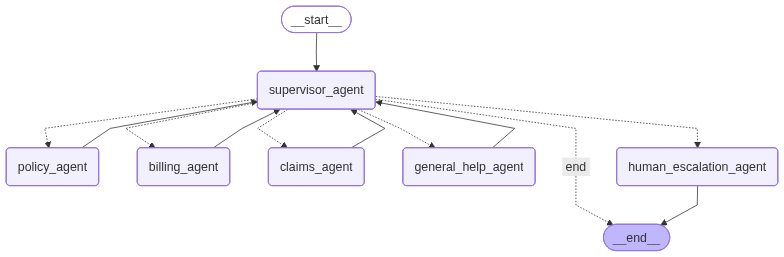

In [58]:
from langgraph.graph import StateGraph, END

def decide_next_agent(state):
    if state.get("end_conversation"):
        return "end"
    return state.get("next_agent", "general_help_agent")

workflow = StateGraph(GraphState)

workflow.add_node("supervisor_agent", supervisor_agent)
workflow.add_node("policy_agent", policy_agent_node, )
workflow.add_node("billing_agent", billing_agent_node)
workflow.add_node("claims_agent", claims_agent_node)
workflow.add_node("general_help_agent", general_help_agent_node)
workflow.add_node("human_escalation_agent", human_escalation_node)

workflow.set_entry_point("supervisor_agent")

workflow.add_conditional_edges(
    "supervisor_agent",
    decide_next_agent,
    {
        "policy_agent": "policy_agent",
        "billing_agent": "billing_agent",
        "claims_agent": "claims_agent",
        "human_escalation_agent": "human_escalation_agent",
        "general_help_agent": "general_help_agent",
        "end": END
    }
)

# Return to Supervisor after each specialist
for node in ["policy_agent", "billing_agent", "claims_agent", "general_help_agent"]:
    workflow.add_edge(node, "supervisor_agent")

# Human escalation → END
workflow.add_edge("human_escalation_agent", END)

app = workflow.compile()


# === Display the Graph ===
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [9]:
def billing_agent_node(state: GraphState):
    """Specialized agent for handling all billing and payment-related queries"""
    user_query = state["user_query"]
    customer_id = state.get("customer_id")
    policy_number = state.get("policy_number")
    
    print(f"Billing Agent: Handling query - {user_query}")
    
    # Billing agent tools (simulated)
    def get_billing_info(cust_id):
        # Simulated database call
        return {
            "current_balance": 245.67,
            "due_date": "2024-01-15",
            "last_payment": 245.67,
            "last_payment_date": "2023-12-15",
            "payment_method": "Credit Card ****1234",
            "billing_frequency": "monthly",
            "next_billing_date": "2024-01-15"
        }
    
    def get_premium_breakdown(policy_num):
        # Simulated premium calculation explanation
        return {
            "base_premium": 180.00,
            "liability_coverage": 45.00,
            "comprehensive": 15.00,
            "collision": 20.67,
            "discounts": -15.00,
            "total": 245.67
        }
    
    def get_payment_failure_details(cust_id):
        # Simulated payment failure lookup
        return {
            "last_failure_date": "2024-01-01",
            "failure_reason": "Insufficient funds",
            "failed_amount": 245.67,
            "retry_scheduled": "2024-01-03"
        }
    
    # Handle different billing scenarios
    response = ""
    
    if "premium" in user_query.lower() and "why" in user_query.lower():
        # Premium explanation
        breakdown = get_premium_breakdown(policy_number)
        response = f"I can explain your premium. Your monthly premium of ${breakdown['total']} consists of:\n"
        response += f"- Base Premium: ${breakdown['base_premium']}\n"
        response += f"- Liability Coverage: ${breakdown['liability_coverage']}\n"
        response += f"- Comprehensive: ${breakdown['comprehensive']}\n"
        response += f"- Collision: ${breakdown['collision']}\n"
        response += f"- Discounts: -${abs(breakdown['discounts'])}\n\n"
        response += "The recent increase is due to updated risk factors in your area."
        
    elif "payment failed" in user_query.lower() or "declined" in user_query.lower():
        # Payment failure handling
        failure_info = get_payment_failure_details(customer_id)
        response = f"I see a payment failure on {failure_info['last_failure_date']}. "
        response += f"Reason: {failure_info['failure_reason']}. "
        response += f"We'll retry on {failure_info['retry_scheduled']}. "
        response += "You can also update your payment method now."
        
    elif "due date" in user_query.lower() or "when is my payment" in user_query.lower():
        # Due date inquiry
        billing_info = get_billing_info(customer_id)
        response = f"Your next payment of ${billing_info['current_balance']} is due on {billing_info['due_date']}. "
        response += f"Your current payment method is {billing_info['payment_method']}."
        
    elif "change payment" in user_query.lower() or "update payment" in user_query.lower():
        # Payment method update
        response = "I can help you update your payment method. "
        response += "For security reasons, I'll need to verify your identity first. "
        response += "Please confirm your date of birth and the last 4 digits of your SSN."
        
    elif "extension" in user_query.lower() or "late" in user_query.lower():
        # Payment extension request
        response = "I can request a 10-day payment extension for you. "
        response += "This will avoid any late fees or coverage interruption. "
        response += "Would you like me to process this extension now?"
        
    else:
        # General billing info
        billing_info = get_billing_info(customer_id)
        response = f"Here's your billing summary:\n"
        response += f"- Current Balance: ${billing_info['current_balance']}\n"
        response += f"- Due Date: {billing_info['due_date']}\n"
        response += f"- Payment Method: {billing_info['payment_method']}\n"
        response += f"- Billing Frequency: {billing_info['billing_frequency']}\n\n"
        response += "How can I help you with your billing today?"
    
    return {
        "messages": [("assistant", response)],
        "billing_amount": 245.67,  # Example extracted data
        "payment_method": "Credit Card"
    }

In [10]:
from langchain_core.messages import HumanMessage, AIMessage
import json

def router_agent(state: GraphState):
    """Enhanced router that can detect billing-related intents"""
    user_query = state["user_query"]
    messages = state["messages"]
    
    # Billing-specific keywords and patterns
    billing_keywords = [
        "payment", "bill", "invoice", "premium", "charge", "billing",
        "credit card", "debit", "bank", "payment method", "auto-pay",
        "due date", "overdue", "late payment", "refund", "amount due",
        "increase", "why did my premium", "payment failed", "declined",
        "update payment", "change payment", "payment extension"
    ]
    
    # System prompt for intent classification
    router_prompt = f"""
    Analyze the user's query and classify their intent. Choose from:
    - "policy_inquiry": Questions about coverage, benefits, policy details
    - "claims_assistance": Starting a new claim or checking claim status
    - "billing_issue": Payment problems, billing questions, premium inquiries
    - "general_help": General FAQ, other questions
    - "human_escalation": User requests human agent or is frustrated
    
    User Query: {user_query}
    
    Respond with JSON only: {{"intent": "detected_intent", "confidence": 0.95}}
    """
    
    # Simulated LLM call - in practice, use your LLM of choice
    # This is a simplified version for demonstration
    detected_intent = "general_help"
    confidence = 0.7
    
    # Check for billing intent
    if any(keyword in user_query.lower() for keyword in billing_keywords):
        detected_intent = "billing_issue"
        confidence = 0.9
    
    # More sophisticated intent detection would go here
    if "premium" in user_query.lower() and "why" in user_query.lower():
        detected_intent = "billing_issue"
        confidence = 0.95
        
    if "payment failed" in user_query.lower() or "declined" in user_query.lower():
        detected_intent = "billing_issue" 
        confidence = 0.98
    
    # Route based on detected intent
    if detected_intent == "policy_inquiry":
        next_agent = "policy_agent"
    elif detected_intent == "claims_assistance":
        next_agent = "claims_agent"
    elif detected_intent == "billing_issue":
        next_agent = "billing_agent"
    elif detected_intent == "human_escalation":
        next_agent = "human_escalation_agent"
    else:
        next_agent = "general_help_agent"
    
    print(f"Router: Detected intent '{detected_intent}' -> Routing to {next_agent}")
    
    return {
        "next_agent": next_agent,
        "user_intent": detected_intent
    }

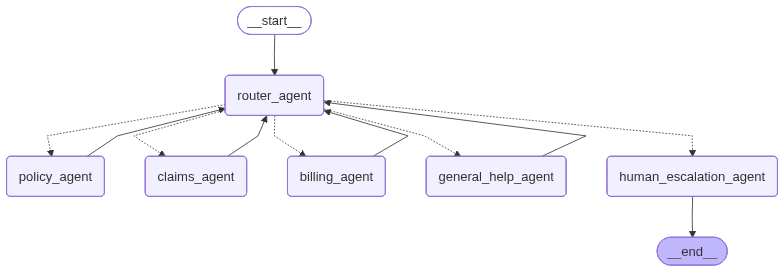

In [35]:
from langgraph.graph import StateGraph, END

def decide_next_agent(state: GraphState):
    """Enhanced router decision function with billing support"""
    next_agent = state.get("next_agent")
    
    routing_map = {
        "policy_agent": "policy_agent",
        "claims_agent": "claims_agent", 
        "billing_agent": "billing_agent",
        "general_help_agent": "general_help_agent",
        "human_escalation_agent": "human_escalation_agent"
    }
    
    return routing_map.get(next_agent, "general_help_agent")

# Build the graph
workflow = StateGraph(GraphState)

# Add all nodes
workflow.add_node("router_agent", router_agent)
workflow.add_node("policy_agent", policy_agent_node)
workflow.add_node("claims_agent", claims_agent_node)
workflow.add_node("billing_agent", billing_agent_node)  # NEW BILLING AGENT
workflow.add_node("general_help_agent", general_help_agent_node)
workflow.add_node("human_escalation_agent", human_escalation_node)

# Set entry point
workflow.set_entry_point("router_agent")

# Add conditional edges FROM the router
workflow.add_conditional_edges(
    "router_agent",
    decide_next_agent,
    {
        "policy_agent": "policy_agent",
        "claims_agent": "claims_agent",
        "billing_agent": "billing_agent",  # NEW ROUTE
        "general_help_agent": "general_help_agent", 
        "human_escalation_agent": "human_escalation_agent",
    }
)

# From specialist agents, route back to router for next user input
workflow.add_edge("policy_agent", "router_agent")
workflow.add_edge("claims_agent", "router_agent")
workflow.add_edge("billing_agent", "router_agent")  # BILLING AGENT RETURNS TO ROUTER
workflow.add_edge("general_help_agent", "router_agent")

# Human escalation ends the conversation
workflow.add_edge("human_escalation_agent", END)

# Compile the graph
app = workflow.compile()


# === Run it ===
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
# Test the system with billing queries
test_queries = [
    "Why did my premium increase this month?",
    "My payment failed yesterday, what should I do?",
    "When is my next payment due?",
    "I need to change my payment method", 
    "Can I get a payment extension?"
]

def run_test_query(query):
    """Test the system with a billing query"""
    initial_state = {
        "messages": [],
        "user_query": query,
        "user_intent": "",
        "customer_id": "cust_12345",
        "policy_number": "pol_67890", 
        "claim_id": "",
        "next_agent": "router_agent",
        "extracted_entities": {},
        "database_lookup_result": {},
        "requires_human_escalation": False,
        "escalation_reason": "",
        "billing_amount": None,
        "payment_method": None,
        "billing_frequency": None,
        "invoice_date": None
    }
    
    print(f"\n{'='*50}")
    print(f"QUERY: {query}")
    print(f"{'='*50}")
    
    # Run the graph
    final_state = app.invoke(initial_state)
    
    # Print the response
    for message in final_state["messages"]:
        if isinstance(message, tuple) and message[0] == "assistant":
            print(f"RESPONSE: {message[1]}")
    
    return final_state

# Test with billing queries
for query in test_queries:
    run_test_query(query)


QUERY: Why did my premium increase this month?
Router: Detected intent 'billing_issue' -> Routing to billing_agent
Billing Agent: Handling query - Why did my premium increase this month?
Router: Detected intent 'billing_issue' -> Routing to billing_agent
Billing Agent: Handling query - Why did my premium increase this month?
Router: Detected intent 'billing_issue' -> Routing to billing_agent
Billing Agent: Handling query - Why did my premium increase this month?
Router: Detected intent 'billing_issue' -> Routing to billing_agent
Billing Agent: Handling query - Why did my premium increase this month?
Router: Detected intent 'billing_issue' -> Routing to billing_agent
Billing Agent: Handling query - Why did my premium increase this month?
Router: Detected intent 'billing_issue' -> Routing to billing_agent
Billing Agent: Handling query - Why did my premium increase this month?
Router: Detected intent 'billing_issue' -> Routing to billing_agent
Billing Agent: Handling query - Why did my p

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/GRAPH_RECURSION_LIMIT